# Streetcar Delay Prediction - Deep Learning - REFACTORED

GOAL: predict streetcar delays using a simple Keras model

Refactored to look at delays by hour by day by route by direction

Source dataset: : https://open.toronto.ca/dataset/ttc-streetcar-delay-data/

# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#bookmark>Deal with missing values</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

# Common imports and global variable definitions

In [105]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import seaborn as sns
# import datetime, timedelta
import datetime
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from pickle import dump
from pickle import load
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
import yaml
import math
import sys
from subprocess import check_output
from IPython.display import display
#model libraries
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
#from tf.keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
#import datetime
#from datetime import date
from sklearn import metrics
# import pipeline libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from custom_classes import encode_categorical
from custom_classes import prep_for_keras_input
from custom_classes import fill_empty
from custom_classes import encode_text


In [106]:
import tensorflow as tf
tf.__version__ 

'2.0.0'

In [107]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, 'streetcar_model_training_config.yml')
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')


current directory is: C:\personal\manning\deep_learning_for_structured_data\notebooks
path_to_yaml C:\personal\manning\deep_learning_for_structured_data\notebooks\streetcar_model_training_config.yml


In [108]:
# load parameters

testproportion = config['test_parms']['testproportion'] # proportion of data reserved for test set
trainproportion = config['test_parms']['trainproportion'] # proportion of non-test data dedicated to training (vs. validation)
verboseout = config['general']['verboseout']
includetext = config['general']['includetext']

presaved = config['general']['presaved']
savemodel = config['general']['savemodel']
picklemodel = config['general']['picklemodel']
hctextmax = config['general']['hctextmax']
maxwords = config['general']['maxwords']
textmax = config['general']['textmax']

targetthresh = config['general']['targetthresh']
targetcontinuous = config['general']['targetcontinuous']

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}



emptythresh = config['general']['emptythresh']
zero_weight = config['general']['zero_weight']
one_weight = config['general']['one_weight']
one_weight_offset = config['general']['one_weight_offset']
patience_threshold = config['general']['patience_threshold']


# modifier for saved model elements
modifier = config['general']['modifier']

# control whether training controlled by early stop
early_stop = True

# default hyperparameter values
learning_rate = config['hyperparameters']['learning_rate']
dropout_rate = config['hyperparameters']['dropout_rate']
l2_lambda = config['hyperparameters']['l2_lambda']
loss_func = config['hyperparameters']['loss_func']
output_activation = config['hyperparameters']['output_activation']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['epochs']

# date values
date_today = datetime.now()
print("date today",date_today)
start_date =  date(config['general']['start_year'],config['general']['start_month'], config['general']['start_day'])
print("start date",start_date)
end_date = date(config['general']['end_year'],config['general']['end_month'], config['general']['end_day'])
print("end date",end_date)


# pickled original dataset and post-preprocessing dataset
pickled_data_file = config['general']['pickled_data_file']
pickled_dataframe = config['general']['pickled_dataframe']
routedirection_file = config['general']['route_direction_file']

# experiment parameter

current_experiment = config['test_parms']['current_experiment']

date today 2020-04-09 23:27:39.723661
start date 2014-01-01
end date 2019-12-31


# Helper functions

In [109]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}


def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)




In [110]:
# get the paths required

def get_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

def get_pipeline_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'pipelines'))
    return(path)

def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [111]:
def set_experiment_parameters(experiment_number, count_no_delay, count_delay):
    ''' set the appropriate parameters for the experiment '''
    print("setting parameters for experiment ", experiment_number)
    # default settings for early stopping:
    es_monitor = "val_loss"
    es_mode = "min"
    if experiment_number == 1:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 10
    elif experiment_number == 2:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 50
    elif experiment_number == 3:
        #
        early_stop = False
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 4:
        #
        early_stop = True
        es_monitor = "val_loss"
        es_mode = "min"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 5:
        #
        early_stop = True
        # if early stopping fails because the level of TensorFlow/Python, comment out the following
        # line and uncomment the subsequent if statement
        es_monitor="val_accuracy"
        '''
        if sys.version_info >= (3,7):
            es_monitor="val_accuracy"
        else:
            es_monitor = "val_acc"
        '''
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    else:
        early_stop = True
    return(early_stop, one_weight, epochs,es_monitor,es_mode)






# Ingest data and create refactored dataframe
- Ingest data for route information and delay information
- Create refactored dataframe with one row per route / direction / timeslot combination

<a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [112]:
# load list of valid routes and directions into dataframe
def ingest_data(path):
    routedirection_frame = pd.read_csv(os.path.join(path,routedirection_file))
    routedirection_frame.tail()
    file_name = os.path.join(path,pickled_dataframe)
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(routedirection_frame, merged_data)

In [113]:
# add derived columns to merged_data dataframe
def prep_merged_data(merged_data):
    # define cols for year month day hour
    merged_data['year'] = pd.DatetimeIndex(merged_data['Report Date']).year
    merged_data['month'] = pd.DatetimeIndex(merged_data['Report Date']).month
    merged_data['daym'] = pd.DatetimeIndex(merged_data['Report Date']).day
    merged_data['hour'] = pd.DatetimeIndex(merged_data['Report Date Time']).hour
    # define time of day column
    merged_data['time_of_day'] = merged_data['hour'].apply(lambda x:get_time(x))
    # add a special timeframe for weekends
    merged_data['time_of_day'] = merged_data.apply(lambda x: weekend_time(x['Day'], x['time_of_day']), axis=1)
    if targetcontinuous:
        merged_data['target'] = merged_data['Min Delay']
    else:
        merged_data['target'] = np.where(merged_data['Min Delay'] >= targetthresh, 1, 0 )
    return(merged_data)

In [114]:
# generate dataframe containing rows for each timeslot for each route for each direction
# and merge with the input merged_data dataframe to get a result of a sparse dataframe with the
# timeslot / route / direction combinations where delays occurred
def prep_sparse_df(routedirection_frame, merged_data):
    routedirection_frame['count'] = 0
    print("routedirection")
    display(routedirection_frame[:5])
    # define a dataframe with a row for each date to be covered
    days = pd.date_range(start_date, end_date, freq='D')
    date_frame = pd.DataFrame({'date':days,'count':0})
    print("date_frame")
    display(date_frame[:5])
    # define a dataframe with a row for each hour
    hour_list = list(range(0,24))
    hour_frame = pd.DataFrame({'hour':hour_list,'count':0})
    print("hour_frame")
    display(hour_frame[:5])
    #vprint(hour_frame.head())
    # merge date_frame and routedirection
    result1 = pd.merge(date_frame, routedirection_frame, on='count', how='outer')
    print("result1")
    display(result1[:5])
    # merge result1 with hour_frame
    result2 = pd.merge(result1, hour_frame, on='count', how='outer')
    result2 = result2.rename(columns={'date': 'Report Date'})
    result2.Route = result2.Route.astype(str)
    # segment the date
    result2['year'] = pd.DatetimeIndex(result2['Report Date']).year
    result2['month'] = pd.DatetimeIndex(result2['Report Date']).month
    result2['daym'] = pd.DatetimeIndex(result2['Report Date']).day
    result2['day'] = pd.DatetimeIndex(result2['Report Date']).weekday
    print("result2")
    display(result2[:5])
    print("merged_data before")
    display(merged_data[:5])
    # drop extraneous columns from merged_data
    merged_data = merged_data.drop(['Time',
     'Report Date Time',
     'year',
     'month',
     'daym',
     'time_of_day','Min Gap','Location','Incident','Vehicle','target','Day'],axis=1)
    print("merged_data after dropping extraneous columns")
    display(merged_data[:5])
    # join result2 and the trimmed merged_data
    result3 = pd.merge(result2,merged_data ,how='left', on=['Report Date','Route','Direction','hour'])
    result3['Min Delay'].fillna(value=0.0,inplace=True)
    result3['target'] = np.where(result3['Min Delay'] > 0.0, 1, 0 )
    print("result3")
    display(result3[:5])
    return(result3)



In [115]:
# REFACTORED DATAFRAME SHOULD HAVE THE FOLLOWING COLUMNS:
# DAY - for every day in the history from Jan 1 2014 to July 31 2018
# HOUR - for every hour of the day
#  for 501, regular route 5:00 am - midnight; 301 overnight
#   for 503: 7- 10:00 am; 4-7:00 pm
# for 504 5:00 am - 2:00 am; 304 overnight
# for 505 5:00 am - 1:00 am
# for 506 5:00 am - 1:00 am; 306 overnight
# for 509 5:00 am - 1:00 am
# for 510 5:00 am - 2:00 am; 310 overnight
# for 511 5:00 am - 1:00 am
# for 512 5:00 am - 2:00 am
# for 514 (Cherry street)
# ROUTE
# DIRECTION
# DELAY - where this could be count OR duration OR binary

# example of filling in values:
# data['PriceDate'] =  pd.to_datetime(data['PriceDate'], format='%m/%d/%Y')
# data = data.sort_values(by=['PriceDate'], ascending=[True])
# data.set_index('PriceDate', inplace=True)
# print (data)

# data = data.resample('D').ffill().reset_index()
# print (data)

# Master Prep Calls
Contains calls to functions to load data, prep input dataframes, and create refactored dataframe

In [116]:
# master calls
# get the path for data files
path = get_path()
print("path is",path)
# load route direction and delay data datframes
directions_df, merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data)
print("shape of pre refactored dataset", merged_data.shape)
merged_data['year'].value_counts()
merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)
# create refactored dataframe with one row for each route / direction / timeslot combination
merged_data = prep_sparse_df(directions_df, merged_data)
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count of no delay ",count_no_delay)
print("count of delay ",count_delay)
# define parameters for the current experiment
experiment_number = 5
early_stop, one_weight, epochs,es_monitor,es_mode = set_experiment_parameters(experiment_number, count_no_delay, count_delay)
print("early_stop is ",early_stop)
print("one_weight is ",one_weight)
print("epochs is ",epochs)
print("es_monitor is ",es_monitor)
print("es_mode is ",es_mode)

path is C:\personal\manning\deep_learning_for_structured_data\data
shape of pre refactored dataset (61500, 17)
routedirection


,Route,Direction,count
0,301,e,0
1,301,w,0
2,301,b,0
3,304,e,0
4,304,e,0


date_frame


,date,count
0,2014-01-01,0
1,2014-01-02,0
2,2014-01-03,0
3,2014-01-04,0
4,2014-01-05,0


hour_frame


,hour,count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


result1


,date,count,Route,Direction
0,2014-01-01,0,301,e
1,2014-01-01,0,301,w
2,2014-01-01,0,301,b
3,2014-01-01,0,304,e
4,2014-01-01,0,304,e


result2


,Report Date,count,Route,Direction,hour,year,month,daym,day
0,2014-01-01,0,301,e,0,2014,1,1,2
1,2014-01-01,0,301,e,1,2014,1,1,2
2,2014-01-01,0,301,e,2,2014,1,1,2
3,2014-01-01,0,301,e,3,2014,1,1,2
4,2014-01-01,0,301,e,4,2014,1,1,2


merged_data before


,Day,Direction,Incident,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle,Report Date Time,year,month,daym,hour,time_of_day,target
Report Date Time,,,,,,,,,,,,,,,,,
2014-01-02 06:31:31,Thursday,e,Late Leaving Garage,dundas and roncesvalles,4.0,8.0,2014-01-02,505,06:31:00,4018,2014-01-02 06:31:31,2014,1,2,6,morning_rush,0
2014-01-02 12:43:43,Thursday,e,Utilized Off Route,king and shaw,20.0,22.0,2014-01-02,504,12:43:00,4128,2014-01-02 12:43:43,2014,1,2,12,midday,1
2014-01-02 14:01:01,Thursday,w,Held By,bingham and kingston road,13.0,19.0,2014-01-02,501,14:01:00,4016,2014-01-02 14:01:01,2014,1,2,14,midday,1
2014-01-02 14:22:22,Thursday,w,Investigation,king st. and roncesvalles,7.0,11.0,2014-01-02,504,14:22:00,4175,2014-01-02 14:22:22,2014,1,2,14,midday,1
2014-01-02 16:42:42,Thursday,e,Utilized Off Route,bathurst and king,3.0,6.0,2014-01-02,504,16:42:00,4080,2014-01-02 16:42:42,2014,1,2,16,aft_rush,0


merged_data after dropping extraneous columns


,Direction,Min Delay,Report Date,Route,hour
Report Date Time,,,,,
2014-01-02 06:31:31,e,4.0,2014-01-02,505,6
2014-01-02 12:43:43,e,20.0,2014-01-02,504,12
2014-01-02 14:01:01,w,13.0,2014-01-02,501,14
2014-01-02 14:22:22,w,7.0,2014-01-02,504,14
2014-01-02 16:42:42,e,3.0,2014-01-02,504,16


result3


,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target
0,2014-01-01,0,301,e,0,2014,1,1,2,0.0,0
1,2014-01-01,0,301,e,1,2014,1,1,2,0.0,0
2,2014-01-01,0,301,e,2,2014,1,1,2,0.0,0
3,2014-01-01,0,301,e,3,2014,1,1,2,0.0,0
4,2014-01-01,0,301,e,4,2014,1,1,2,0.0,0


shape of refactored dataset (2952587, 11)
count of no delay  2892594
count of delay  59993
setting parameters for experiment  5
early_stop is  True
one_weight is  48.21552514460021
epochs is  50
es_monitor is  val_accuracy
es_mode is  max


In [117]:
merged_data.shape

(2952587, 11)

# Define test / training sets; encode categorical values; process text field


In [118]:
# get training and test data set
def get_train_validation_test(dataset):
    train, test = train_test_split(dataset, test_size = testproportion)
    dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)
    print("Through train test split. Test proportion:")
    print(testproportion)
    return(dtrain,dvalid,test)



# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [119]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['Report Date', 'count', 'Route', 'Direction', 'hour', 'year', 'month', 'daym', 'day', 'Min Delay', 'target']


In [120]:
# define the required column lists
def def_col_lists():
    textcols = [] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
    continuouscols = [] # columns to deal with as continuous values - no embeddings
    if targetcontinuous:
        excludefromcolist = ['count','Report Date', 'target','count_md','Min Delay'] # columns to exclude completely from the model

    else:
        # if target column is not renamed Min Delay put Min Delay in exclusion list
        excludefromcolist = ['count','Report Date', 'target','count_md', 'Min Delay'] # columns to exclude completely from the model
    nontextcols = list(set(allcols) - set(textcols))
    collist = list(set(nontextcols) - set(excludefromcolist) - set(continuouscols))
    for col in continuouscols:
        print("col is",col)
        merged_data[col] = merged_data[col].astype(float)
        print("got through one")
        superset_data[col] = superset_data[col].astype(float)
    # print column list lengths and contents:
    print("allcols",len(allcols))
    print("excludefromcolist",len(excludefromcolist))
    print(excludefromcolist)
    print("textcols",len(textcols))
    print(textcols)
    print("continuouscols",len(continuouscols))
    print(continuouscols)
    print("collist",len(collist))
    print(collist)
    return(collist,continuouscols,textcols)

# Invoke Pipeline

In [121]:
# define keras variables


# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))

    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))

    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))

    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input






In [122]:
# master block to invoke pipeline

# build fully qualified names for the files for saving the pipelines
pipeline_path = get_pipeline_path()
pipeline1_file_name = os.path.join(pipeline_path,'sc_delay_pipleline'+modifier+'.pkl')
pipeline2_file_name = os.path.join(pipeline_path,'sc_delay_pipleline_keras_prep'+modifier+'.pkl')

# define column lists:
collist,continuouscols,textcols = def_col_lists()

# create objects of the pipeline classes
fe = fill_empty()
ec = encode_categorical()
pk = prep_for_keras_input()

# need to implement the pipeline in two parts:
# 1. fill empty + encode categoricals
# 2. prep for Keras
# because part 1 needs to be applied to the entire dataset and part 2 to the individual train, validate, and test sets


sc_delay_pipeline = Pipeline([('fill_empty',fe),('encode_categorical',ec)])
sc_delay_pipeline_keras_prep = Pipeline([('prep_for_keras',pk)])



# provide the value for each parameter of each of the pipeline classes

sc_delay_pipeline.set_params(fill_empty__collist = collist, fill_empty__continuouscols = continuouscols,
                            fill_empty__textcols = textcols,encode_categorical__col_list = collist)
sc_delay_pipeline_keras_prep.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)

# fit the input dataset to the pipeline

# first fit the first segment of pipeline on the whole dataset
X = sc_delay_pipeline.fit_transform(merged_data)
max_dict = ec.max_dict
# then split dataset
dump(sc_delay_pipeline, open(pipeline1_file_name,'wb'))
dump(sc_delay_pipeline_keras_prep, open(pipeline2_file_name,'wb'))
dtrain, dvalid, test = get_train_validation_test(X)
# then apply second portion of pipeline to each subset

X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)

print("keras variables defined")
print("X_train_list",X_train_list)



allcols 11
excludefromcolist 5
['count', 'Report Date', 'target', 'count_md', 'Min Delay']
textcols 0
[]
continuouscols 0
[]
collist 7
['month', 'day', 'year', 'Direction', 'daym', 'hour', 'Route']
fill empty xform
col is  month
col is  day
col is  year
col is  Direction
col is  daym
col is  hour
col is  Route
transform col is  month
after transform col is  month
transform col is  day
after transform col is  day
transform col is  year
after transform col is  year
transform col is  Direction
after transform col is  Direction
transform col is  daym
after transform col is  daym
transform col is  hour
after transform col is  hour
transform col is  Route
after transform col is  Route
Through train test split. Test proportion:
0.2
cat col is month
cat col is day
cat col is year
cat col is Direction
cat col is daym
cat col is hour
cat col is Route
cat col is month
cat col is day
cat col is year
cat col is Direction
cat col is daym
cat col is hour
cat col is Route
cat col is month
cat col is d

# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [123]:
# define model in Keras

def get_model():


    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings


    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])



    # define layers for text columns
    if includetext:
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col]))
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")

    # define layers for continuous columns
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])



    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])

    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])

    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])

    print("main_l", main_l)



    # define output layer
    output = Dense(1, activation=output_activation) (main_l)

    # define model

    model = Model(inputlayerlist, output)


    # define optimizer
    optimizer = SGD(lr=learning_rate)

    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])


    return model


model = get_model()

#plot_model(model, to_file='/home/paperspace/visualizations/streetcarmodel_dec16.png', show_shapes=True, show_layer_names=True)

# output model summary

model.summary()




about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_29/Identity:0", shape=(None, 70), dtype=float32)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
day (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 1, 10)        120         month[0][0]                      
__________________________________________________________________________________________________
embe

In [124]:
# set up early stopping
def set_early_stop(es_monitor, es_mode):
    es = EarlyStopping(monitor=es_monitor, mode=es_mode, verbose=1,patience = patience_threshold)
    model_path = get_model_path()
    # save_model_path = path+'models/'+'scmodel'+modifier+"_"+str(experiment_number)+'.h5'
    save_model_path = os.path.join(model_path,'scmodel'+modifier+"_"+str(experiment_number)+'.h5')
    mc = ModelCheckpoint(save_model_path, monitor=es_monitor, mode=es_mode, verbose=1, save_best_only=True)
    return(es,mc,save_model_path)

In [125]:
%%time
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",batch_size)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)
print("patienc_threshold is ",patience_threshold)
# get definitions
es, mc, save_model_path = set_early_stop(es_monitor, es_mode)
model = get_model()
if early_stop:
       modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
        , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1,callbacks=[es,mc])
else:
    modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
         , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

text cols []
dropout  0.0003
L2 lambda  0.0003
batch size  1000
epochs 50
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
patienc_threshold is  15
about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_35/Identity:0", shape=(None, 70), dtype=float32)
Train on 1889655 samples, validate on 472414 samples
Epoch 1/50
1889000/1889655 [============================>.] - ETA: 0s - loss: 1.0590 - accuracy: 0.5860 - accuracy_1: 0.7198
Epoch 00001: val_accuracy improved from -inf to 0.67664, saving model to C:\personal\manning\deep_learning_for_structured_data\models\scmodelapr9c_2020_5.h5
1889655/1889655 [==============================] - 21s 11us/sample - loss: 1.0589 - accuracy: 0.5861 - accuracy_1: 0.7198 - val_loss: 0.5768 - val_accuracy: 0.6766 - val_accuracy_1: 0.6766
Epoch 2/50
1883000/1889655 [============================>.] - ETA: 0s - loss: 0.9105 - accuracy:

Epoch 21/50
1882000/1889655 [============================>.] - ETA: 0s - loss: 1.7512 - accuracy: 0.7269 - accuracy_1: 0.7476
Epoch 00021: val_accuracy did not improve from 0.75447
1889655/1889655 [==============================] - 14s 7us/sample - loss: 1.7518 - accuracy: 0.7270 - accuracy_1: 0.7476 - val_loss: 0.5071 - val_accuracy: 0.7307 - val_accuracy_1: 0.7307
Epoch 22/50
1884000/1889655 [============================>.] - ETA: 0s - loss: 1.7048 - accuracy: 0.7408 - accuracy_1: 0.7564
Epoch 00022: val_accuracy did not improve from 0.75447
1889655/1889655 [==============================] - 14s 7us/sample - loss: 1.7033 - accuracy: 0.7408 - accuracy_1: 0.7565 - val_loss: 0.4881 - val_accuracy: 0.7431 - val_accuracy_1: 0.7431
Epoch 23/50
1882000/1889655 [============================>.] - ETA: 0s - loss: 1.6785 - accuracy: 0.7457 - accuracy_1: 0.7587
Epoch 00023: val_accuracy did not improve from 0.75447
1889655/1889655 [==============================] - 15s 8us/sample - loss: 1.6776 

Epoch 43/50
1887000/1889655 [============================>.] - ETA: 0s - loss: 2.2615 - accuracy: 0.7845 - accuracy_1: 0.7864
Epoch 00043: val_accuracy did not improve from 0.81642
1889655/1889655 [==============================] - 14s 7us/sample - loss: 2.2612 - accuracy: 0.7845 - accuracy_1: 0.7865 - val_loss: 0.4135 - val_accuracy: 0.7845 - val_accuracy_1: 0.7845
Epoch 44/50
1884000/1889655 [============================>.] - ETA: 0s - loss: 2.2562 - accuracy: 0.7856 - accuracy_1: 0.7862
Epoch 00044: val_accuracy did not improve from 0.81642
1889655/1889655 [==============================] - 14s 7us/sample - loss: 2.2549 - accuracy: 0.7856 - accuracy_1: 0.7863 - val_loss: 0.4120 - val_accuracy: 0.7850 - val_accuracy_1: 0.7850
Epoch 45/50
1885000/1889655 [============================>.] - ETA: 0s - loss: 2.2498 - accuracy: 0.7858 - accuracy_1: 0.7867
Epoch 00045: val_accuracy did not improve from 0.81642
1889655/1889655 [==============================] - 14s 8us/sample - loss: 2.2516 

In [126]:
# save model elements explicitly if not saved as part of early_stop
if early_stop == False:
    model_json = model.to_json()
    model_path = get_model_path()
    with open(os.path.join(model_path,'model'+modifier+'.json'), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(os.path.join(model_path,'scweights'+modifier+'.h5'))
    save_model_path = os.path.join(model_path,'scmodel'+modifier+'.h5')
    model.save(save_model_path,save_format='h5')
    print("Saved model, weights to disk")


In [127]:
saved_model = load_model(save_model_path)
if len(saved_model.metrics_names) == 2:
    # saved_model.evaluate returns ['loss', 'acc']
    _, train_acc = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
    _, test_acc = saved_model.evaluate(X_test, test.target, verbose=0)
else:
    # saved_model.evaluate returns ['loss', 'accuracy', 'accuracy_1']
    _, train_acc,_ = saved_model.evaluate(X_train_list, dtrain.target, verbose=0)
    _, test_acc,_ = saved_model.evaluate(X_test, test.target, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))



Train: 0.817, Test: 0.816


In [128]:
X_train_list

[array([8, 9, 4, ..., 0, 8, 1], dtype=int64),
 array([0, 6, 1, ..., 6, 3, 3], dtype=int64),
 array([5, 5, 1, ..., 4, 2, 1], dtype=int64),
 array([1, 1, 0, ..., 0, 0, 0]),
 array([ 8, 26, 18, ..., 27, 14, 25], dtype=int64),
 array([21, 23, 16, ..., 10, 20, 21], dtype=int64),
 array([ 7,  8,  7, ...,  3,  4, 11])]

In [129]:
X_train_list[0]

array([8, 9, 4, ..., 0, 8, 1], dtype=int64)

# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [130]:
saved_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
day (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 1, 10)        120         month[0][0]                      
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 1, 10)        70          day[0][0]                        
____________________________________________________________________________________________

In [131]:
if presaved == True:
    batch_size = 1000
    epochs = 1
    modelfit2 = loaded_model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
         , validation_data=(X_valid_list, dvalid.target), verbose=1)

# Predictions and renderings

In [132]:
# functions to parse and manipulate dates in the style of the input CSVs

def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [133]:
type(X_test)

dict

In [134]:
list(X_test_list[0])

[10,
 9,
 0,
 6,
 0,
 5,
 9,
 0,
 10,
 8,
 2,
 11,
 10,
 3,
 8,
 2,
 1,
 5,
 4,
 9,
 7,
 6,
 2,
 3,
 2,
 10,
 9,
 10,
 0,
 6,
 10,
 9,
 2,
 9,
 7,
 0,
 5,
 7,
 10,
 10,
 4,
 3,
 6,
 7,
 5,
 9,
 10,
 6,
 11,
 5,
 9,
 0,
 1,
 3,
 8,
 8,
 6,
 8,
 4,
 0,
 5,
 10,
 9,
 5,
 11,
 5,
 2,
 10,
 6,
 2,
 8,
 6,
 1,
 10,
 7,
 8,
 2,
 11,
 7,
 1,
 2,
 7,
 5,
 8,
 2,
 2,
 4,
 5,
 1,
 4,
 10,
 2,
 11,
 3,
 2,
 6,
 3,
 1,
 6,
 4,
 6,
 5,
 5,
 10,
 5,
 3,
 5,
 8,
 2,
 6,
 2,
 5,
 0,
 4,
 9,
 9,
 2,
 11,
 3,
 8,
 1,
 9,
 3,
 10,
 5,
 6,
 4,
 10,
 2,
 0,
 6,
 5,
 3,
 3,
 3,
 2,
 11,
 8,
 0,
 0,
 4,
 9,
 1,
 1,
 11,
 3,
 8,
 7,
 6,
 5,
 1,
 2,
 6,
 0,
 6,
 1,
 0,
 4,
 6,
 7,
 3,
 2,
 1,
 10,
 7,
 2,
 10,
 0,
 9,
 3,
 6,
 6,
 0,
 3,
 0,
 5,
 9,
 9,
 0,
 1,
 2,
 3,
 7,
 1,
 8,
 4,
 7,
 3,
 5,
 5,
 9,
 1,
 8,
 10,
 6,
 2,
 2,
 11,
 4,
 10,
 10,
 8,
 6,
 8,
 11,
 7,
 10,
 8,
 2,
 4,
 6,
 0,
 10,
 9,
 8,
 4,
 10,
 1,
 5,
 4,
 10,
 6,
 8,
 10,
 2,
 10,
 5,
 2,
 7,
 3,
 4,
 5,
 6,
 4,
 8,
 3,
 4,
 11,
 4,
 1,
 2

In [135]:
print("X_test ", X_test)

X_test  {'month': array([10,  9,  0, ...,  7, 11,  0], dtype=int64), 'day': array([1, 4, 5, ..., 3, 6, 2], dtype=int64), 'year': array([5, 2, 3, ..., 1, 3, 2], dtype=int64), 'Direction': array([1, 4, 1, ..., 4, 0, 4]), 'daym': array([11,  6, 13, ..., 19,  9, 19], dtype=int64), 'hour': array([ 8,  6, 23, ..., 12,  7, 20], dtype=int64), 'Route': array([11,  4,  8, ...,  2,  8, 10])}


In [136]:
# predictions on training set

preds = saved_model.predict(X_test, batch_size=batch_size)

In [137]:
preds.shape

(590518, 1)

C:\personal\manning\tf2_test\notebooks\try_tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


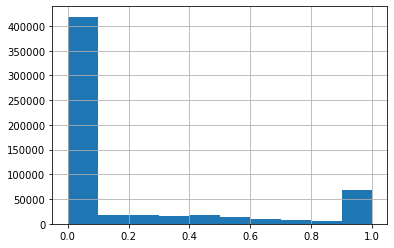

In [138]:
test["predict"] = preds
test.predict[:5]
if verboseout:
    test.predict.hist()

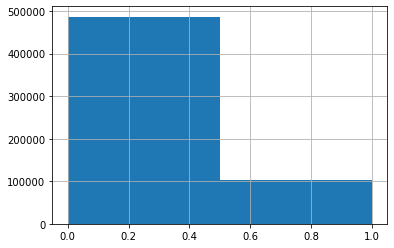

In [139]:
if verboseout:
    test.predict.hist(bins=2)

In [140]:
# get rounded predictions
test["predround"] = preds.round().astype(int)
test.predround[:5]

C:\personal\manning\tf2_test\notebooks\try_tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2886392    1
1361636    0
1495564    1
2717436    1
1008887    0
Name: predround, dtype: int32

In [141]:
print("test target 0",test[test['target']==0].shape[0])
print("test target 1",test[test['target']==1].shape[0])
print("test predround 0",test[test['predround']==0].shape[0])
print("test predround 1",test[test['predround']==1].shape[0])

test target 0 578746
test target 1 11772
test predround 0 486761
test predround 1 103757


In [142]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(test.target[:100000] - test.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct test")
print((len(deltatr) - deltatr.sum())/len(deltatr))



18452
percentage correct test
0.81548


In [143]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=batch_size)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





1470262    0.000000
1848352    0.460441
2397935    0.363423
2631880    0.466970
1946595    0.485333
Name: predict, dtype: float32

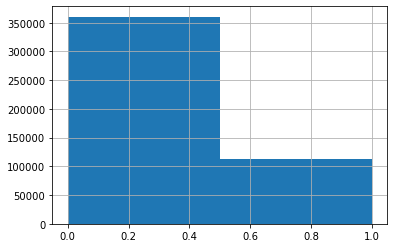

In [144]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [145]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


1470262    0
1848352    0
2397935    0
2631880    0
1946595    0
519518     0
1742900    0
452603     0
291366     1
1092727    1
Name: deltaval, dtype: int32
106653


In [146]:
# hand calculation of proportion correct guesses in validation set

test["deltaval"] = abs(test.target - test.predround)
print(test["deltaval"][:10])
print(test["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))

2886392    1
1361636    0
1495564    1
2717436    1
1008887    0
2694633    0
1852168    0
2465492    1
2885901    0
2300204    0
Name: deltaval, dtype: int32
108675


C:\personal\manning\tf2_test\notebooks\try_tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [147]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predround,predict,deltaval
291366,2014-08-05,0,4,1,18,0,7,4,1,0.0,0,1,0.683753,1
1092727,2016-03-21,0,11,3,7,2,2,20,0,0.0,0,1,0.505934,1
1313686,2016-09-01,0,9,3,19,2,8,0,3,0.0,0,1,0.705188,1
501221,2015-01-07,0,13,4,23,1,0,6,2,0.0,0,1,0.533918,1
1774276,2017-08-09,0,8,1,9,3,7,8,2,0.0,0,1,0.608416,1
116487,2014-03-28,0,8,1,10,0,2,27,4,0.0,0,1,0.646234,1
848079,2015-09-22,0,5,4,15,1,8,21,1,10.0,1,0,0.497958,1
962893,2015-12-16,0,9,1,20,1,11,15,2,0.0,0,1,0.628961,1
2179264,2018-06-05,0,13,4,10,4,5,4,1,0.0,0,1,0.620226,1
2620068,2019-04-28,0,11,1,18,5,3,27,6,0.0,0,1,0.555993,1


In [148]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
testwrong = test.loc[(test.deltaval == 1)]
testright = test.loc[(test.deltaval == 0)]
testwrong.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predict,predround,deltaval
2886392,2019-11-12,0,11,1,8,5,10,11,1,0.0,0,1.000000,1,1
1495564,2017-01-14,0,8,1,23,3,0,13,5,0.0,0,1.000000,1,1
2717436,2019-07-10,0,2,1,3,5,6,9,2,0.0,0,1.000000,1,1
2465492,2019-01-04,0,2,1,12,5,0,3,4,0.0,0,0.705028,1,1
2090772,2018-04-01,0,7,1,5,4,3,0,6,0.0,0,1.000000,1,1
305162,2014-08-15,0,8,1,8,0,7,14,4,0.0,0,1.000000,1,1
1742655,2017-07-17,0,0,1,3,3,6,16,0,0.0,0,1.000000,1,1
431866,2014-11-17,0,8,1,17,0,10,16,0,0.0,0,1.000000,1,1
418411,2014-11-07,0,8,1,18,0,10,6,4,0.0,0,1.000000,1,1
2169363,2018-05-29,0,9,3,17,4,4,28,1,0.0,0,0.571548,1,1


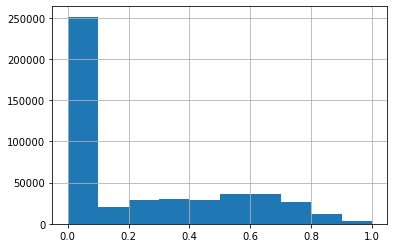

In [149]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

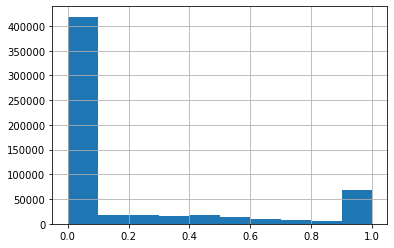

In [150]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
test.predict.hist()

In [151]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


22504
percentage correct validate
0.77496


dict_keys(['loss', 'accuracy', 'accuracy_1', 'val_loss', 'val_accuracy', 'val_accuracy_1'])


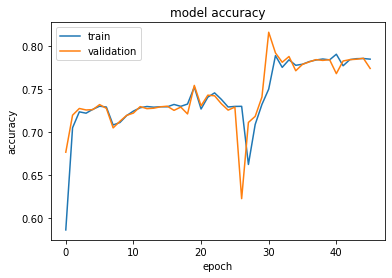

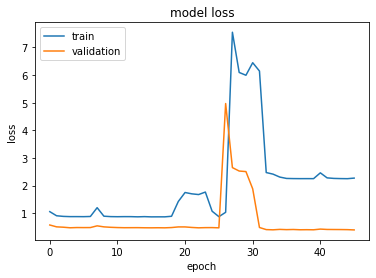

In [152]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['accuracy'])
plt.plot(modelfit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

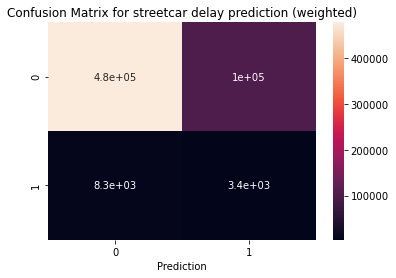

In [153]:


cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=test["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction (weighted)")
plt.show()

In [154]:
model.metrics_names

['loss', 'accuracy', 'accuracy_1']

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at Intact Insurance.